In [ ]:
%pip install netCDF4
%pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 17.5 MB/s eta 0:00:00


# Function to read the netCDF Data files

In [ ]:
import numpy as np
import pandas as pd
import netCDF4
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


# Function to load NetCDF data
def read_nc(filename):
    """
    Function read_nc
    Read a monthly climate data netCDF file and extract map series and dates
    :param filename: filename as a string
    :returns: (map series: numpy array(month,lat,lon), dates: list[(year,month)])
    """
    nc = netCDF4.Dataset(filename)
    # the temperature data could be called different things -
    # this trick picks the data element with the highest number of dimensions
    key = sorted([(nc.variables[k].ndim, k) for k in nc.variables])[-1][1]
    tmaps = np.ma.filled(nc.variables[key][:, :, :], np.nan)
    time1 = nc.variables["time"][:]
    unit1 = nc.variables["time"].units
    latitudes = nc.variables["latitude"][:]
    longitudes = nc.variables["longitude"][:]
    dates = netCDF4.num2date(time1, units=unit1)
    dates = pd.to_datetime([str(date) for date in dates])
    return tmaps, dates, latitudes, longitudes

In [ ]:
# read in data from .nc file
tmaps_glosatlat, dates_glosatlat, latitudes_glosatlat, longitudes_glosatlat = read_nc("/content/drive/MyDrive/Project_files/Netcdf files/GloSATLAT_5.0.1.3.anomalies (1).nc")
# read in data from .nc file
tmaps_glosatmat_filled, dates_glosatmat_filled, latitudes_glosatmat_filled, longitudes_glosatmat_filled = read_nc("/content/drive/MyDrive/Project_files/Netcdf files/GloSATMAT_filled_masked.nc")

# Function to reduce the grid size to 10 degree grid

In [ ]:
# Reduce to 10 degree grid
def reduce_grid_size(tmaps):
    tmaps_reduced = tmaps.reshape([tmaps.shape[0], tmaps.shape[1] // 2, 2, tmaps.shape[2] // 2, 2])
    tmaps_reduced = np.nanmean(tmaps_reduced, axis=(2, 4))
    return tmaps_reduced

tmaps_glosatlat_reduced = reduce_grid_size(tmaps_glosatlat)
tmaps_glosatmat_filled_reduced = reduce_grid_size(tmaps_glosatmat_filled)

# Define reduced latitudes and longitudes
reduced_latitudes = latitudes_glosatlat[::2]
reduced_longitudes = longitudes_glosatlat[::2]

<ipython-input-4-481563aec027>:4: RuntimeWarning: Mean of empty slice
  tmaps_reduced = np.nanmean(tmaps_reduced, axis=(2, 4))


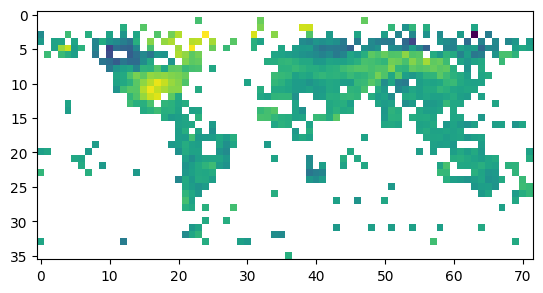

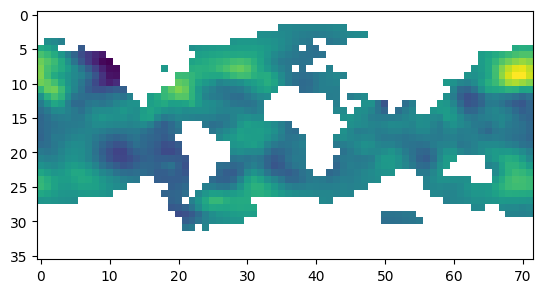

In [ ]:
# check coverage
import matplotlib.pyplot as plt
plt.imshow(tmaps_glosatlat[-1,::-1,:])
plt.show()
plt.imshow(tmaps_glosatmat_filled[-1,::-1,:])
plt.show()

In [ ]:
 #get time series and derivatives from monthly means with incomplete data
def series_from_monthly_means(ymean, end_na=1):
  """
  Function series_from_monthly_means
  Take a series of monthly means are return monthly centre value and derivative
  :param ymean: time series of monthly means
  :param end_na: number of points to set to NA at the ends of the series (default:1)
  :returns: (time series of values, time series of derivative)
  """
  n = len(ymean)
  tmat = (1.0 * np.eye(n, n, -1) + 4.0 * np.eye(n, n, 0) + 1.0 * np.eye(n, n, 1)) / 6.0
  cp = np.linalg.solve(tmat, ymean)
  y = np.convolve(cp, [1.0 / 8.0, 6.0 / 8.0, 1.0 / 8.0], mode="same")
  dy = np.convolve(cp, [0.5, 0.0, -0.5], mode="same")
  if end_na:
      y[: end_na] = np.nan
      y[-end_na:] = np.nan
      dy[: end_na] = np.nan
      dy[-end_na:] = np.nan
  return y, dy

In [ ]:
# Function to calculate series with incomplete data
def series_from_monthly_means_incomplete(ymean, end_na=1, min_obs=12 ):
  """
  Function series_from_monthly_means_incomplete
  Take a series of monthly means are return monthly centre value and derivative
  :param ymean: time series of monthly means
  :param end_na: number of points to set to NA at the ends of the series (default:1)
  :returns: (time series of values, time series of derivative)
  """
  # get indices of non-missings
  i0 = np.nonzero(~np.isnan(ymean))[0]
  # find non-missing ranges
  i1 = np.roll(i0, 1)+1
  i2 = np.roll(i0,-1)-1
  i1 = i0[np.nonzero(i0!=i1)[0]]  # range start
  i2 = i0[np.nonzero(i0!=i2)[0]]  # range end
  assert np.sum(i2-i1+1) == np.count_nonzero(~np.isnan(ymean))
  # output arrays
  yfull  = np.full_like(ymean,np.nan)
  dyfull = np.full_like(ymean,np.nan)
  # gather data from ranges
  for i in range(len(i1)):
    # check there are sufficient data in range
    if (i2[i]-i1[i]>min_obs):
      #print(i0,i1[i],i2[i])
      yrange = ymean[i1[i]:i2[i]+1]
      y,dy = series_from_monthly_means(yrange,end_na)
      yfull[i1[i]:i2[i]+1]  = y
      dyfull[i1[i]:i2[i]+1] = dy
  return yfull,dyfull

In [ ]:
# Dataframe for 1961-1990 (GloSATLAT vs GloSATMAT_FILLED)
start_date_1961 = pd.to_datetime('1961-01-16')
end_date_1990 = pd.to_datetime('1990-12-16')

# Creating the dataframe for specific time intervals over the loops

In [ ]:
data_1961_1990 = []
for lat in range(tmaps_glosatlat_reduced.shape[1]):
    for lon in range(tmaps_glosatlat_reduced.shape[2]):
        glosatlat_series = tmaps_glosatlat_reduced[:, lat, lon]
        glosatmat_filled_series = tmaps_glosatmat_filled_reduced[:, lat, lon]

        y1, dy1 = series_from_monthly_means_incomplete(glosatlat_series, 1, 12) # land
        y2, dy2 = series_from_monthly_means_incomplete(glosatmat_filled_series, 1, 12) # ocean

        for i in range(len(dates_glosatlat)):
            if start_date_1961 <= dates_glosatlat[i] <= end_date_1990 and not np.isnan(dy1[i]) and not np.isnan(dy2[i]):
                data_1961_1990.append({
                    'date': dates_glosatlat[i],
                    'dTo': dy2[i],
                    'To': y2[i],
                    'dTs': dy1[i],
                    'Ts': y1[i],
                    'lat': lat,
                    'lon': lon
                })

In [ ]:
df_1961_1990 = pd.DataFrame(data_1961_1990)
df_1961_1990 = df_1961_1990.sort_values(by='date')
df_1961_1990 = df_1961_1990.dropna(subset=['dTs', 'To', 'Ts', 'dTo'])
df_1961_1990.reset_index(drop=True, inplace=True)

In [ ]:
df_1961_1990

,date,dTo,To,dTs,Ts,lat,lon
0,1961-01-16 12:00:00,0.108556,0.237999,-0.096279,0.002156,9,12
1,1961-01-16 12:00:00,0.165570,1.672024,-6.039735,-1.716154,16,12
2,1961-01-16 12:00:00,0.216618,0.223448,0.031769,0.319164,7,27
3,1961-01-16 12:00:00,1.783625,-0.912097,4.671567,1.779135,14,34
4,1961-01-16 12:00:00,0.603376,0.106765,-0.118154,0.751433,8,9
...,...,...,...,...,...,...,...
76500,1990-11-16 00:00:00,-0.086351,1.072882,0.055272,2.954393,13,21
76501,1990-11-16 00:00:00,0.041710,-0.473821,2.713971,-2.742414,15,20
76502,1990-11-16 00:00:00,-0.200658,0.086471,-0.110653,0.217838,7,27
76503,1990-11-16 00:00:00,0.132771,0.038605,-0.085227,-0.005027,9,29


In [ ]:
# Dataframe for 1991-2020 (GloSATLAT vs GloSATMAT_filled)
start_date_1991 = pd.to_datetime('1991-01-16')
end_date_2020 = pd.to_datetime('2020-12-16')
data_1991_2020 = []

# loop over cells
for lat in range(tmaps_glosatlat_reduced.shape[1]):
    for lon in range(tmaps_glosatlat_reduced.shape[2]):
        glosatlat_series = tmaps_glosatlat_reduced[:, lat, lon]
        glosatmat_filled_series = tmaps_glosatmat_filled_reduced[:, lat, lon]

        y1, dy1 = series_from_monthly_means_incomplete(glosatlat_series, 1, 12) # land
        y2, dy2 = series_from_monthly_means_incomplete(glosatmat_filled_series, 1, 12) # ocean

        for i in range(len(dates_glosatlat)):
            if start_date_1991 <= dates_glosatlat[i] <= end_date_2020 and not np.isnan(dy1[i]) and not np.isnan(dy2[i]):
                data_1991_2020.append({
                    'date': dates_glosatlat[i],
                    'dTo': dy2[i],
                    'To': y2[i],
                    'dTs': dy1[i],
                    'Ts': y1[i],
                    'lat': lat,
                    'lon': lon
                })


In [ ]:
df_1991_2020 = pd.DataFrame(data_1991_2020)
df_1991_2020 = df_1991_2020.sort_values(by='date')
df_1991_2020 = df_1991_2020.dropna(subset=['dTs', 'To', 'Ts', 'dTo'])
df_1991_2020.reset_index(drop=True, inplace=True)

In [ ]:
df_1991_2020

,date,dTo,To,dTs,Ts,lat,lon
0,1991-01-16 12:00:00,0.182360,0.794281,0.264383,0.225499,2,11
1,1991-01-16 12:00:00,0.049871,0.435982,0.265461,0.009763,7,33
2,1991-01-16 12:00:00,0.859944,0.704673,1.286104,2.363124,15,15
3,1991-01-16 12:00:00,-0.343923,0.306500,-1.094249,-0.500717,7,32
4,1991-01-16 12:00:00,-0.627851,0.423616,-1.660035,-0.083723,7,31
...,...,...,...,...,...,...,...
69300,2020-11-16 00:00:00,-0.763202,0.453563,0.812554,1.316850,11,23
69301,2020-11-16 00:00:00,-0.851599,0.636187,1.072116,2.225887,11,22
69302,2020-11-16 00:00:00,0.216516,-0.052788,-0.434532,1.147968,7,2
69303,2020-11-16 00:00:00,-0.064484,0.444975,-0.354501,0.652906,7,0


# Calculating the grid values A, B, C by fitting the temperature anomalies and thier derivatives in OLS regression

In [ ]:
# Calculating coefficients for 1960-1990
A_grid_1961_1990 = np.full((tmaps_glosatlat_reduced.shape[1], tmaps_glosatlat_reduced.shape[2]), np.nan)
B_grid_1961_1990 = np.full((tmaps_glosatlat_reduced.shape[1], tmaps_glosatlat_reduced.shape[2]), np.nan)
C_grid_1961_1990 = np.full((tmaps_glosatlat_reduced.shape[1], tmaps_glosatlat_reduced.shape[2]), np.nan)

# loop over cells
for lat in range(tmaps_glosatlat_reduced.shape[1]):
    for lon in range(tmaps_glosatlat_reduced.shape[2]):
        grid_data = df_1961_1990[(df_1961_1990['lat'] == lat) & (df_1961_1990['lon'] == lon)]
        if len(grid_data) >= 200:
            # construct equations
            y = grid_data['dTo']
            X = grid_data[['dTs', 'To', 'Ts']]
            X = sm.add_constant(X)  # Add the constant term
            model = sm.OLS(y, X).fit()
            A_grid_1961_1990[lat, lon] = model.params['dTs']
            B_grid_1961_1990[lat, lon] = -model.params['To']/2.63e6
            C_grid_1961_1990[lat, lon] = model.params['Ts']/2.63e6

# Displaying the Coefficeint Values of A, B, C from the period 1961-1990

In [ ]:
A_grid_1961_1990, B_grid_1961_1990, C_grid_1961_1990

(array([[       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
            

In [ ]:
# Calculating coefficients for 1990-2020
A_grid_1991_2020 = np.full((tmaps_glosatlat_reduced.shape[1], tmaps_glosatlat_reduced.shape[2]), np.nan)
B_grid_1991_2020 = np.full((tmaps_glosatlat_reduced.shape[1], tmaps_glosatlat_reduced.shape[2]), np.nan)
C_grid_1991_2020 = np.full((tmaps_glosatlat_reduced.shape[1], tmaps_glosatlat_reduced.shape[2]), np.nan)
# loop over cells
for lat in range(tmaps_glosatlat_reduced.shape[1]):
    for lon in range(tmaps_glosatlat_reduced.shape[2]):
        grid_data = df_1991_2020[(df_1991_2020['lat'] == lat) & (df_1991_2020['lon'] == lon)]
        if len(grid_data) >= 200:
            # construct equations
            y = grid_data['dTo']
            X = grid_data[['dTs', 'To', 'Ts']]
            X = sm.add_constant(X)  # Add the constant term
            model = sm.OLS(y, X).fit()
            A_grid_1991_2020[lat, lon] = model.params['dTs']
            B_grid_1991_2020[lat, lon] = -model.params['To']/2.63e6
            C_grid_1991_2020[lat, lon] = model.params['Ts']/2.63e6

# Displaying the Coefficient Values of A, B, C from the period 1991-2020

In [ ]:
A_grid_1991_2020, B_grid_1991_2020, C_grid_1991_2020

(array([[        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan],
        [        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
               

# Outlier detection and removing those for final analysis using Z score and iqr methods

In [ ]:
def identify_outliers(data, method='zscore', threshold=3):
    if method == 'zscore':
        mean = np.nanmean(data)
        std = np.nanstd(data)
        z_scores = (data - mean) / std
        outliers = np.abs(z_scores) > threshold
    elif method == 'iqr':
        q1 = np.nanpercentile(data, 25)
        q3 = np.nanpercentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = (data < lower_bound) | (data > upper_bound)
    else:
        raise ValueError("Unsupported method. Choose 'zscore' or 'iqr'.")
    return outliers

In [ ]:
def remove_outliers(data, outliers):
    data_cleaned = np.copy(data)
    data_cleaned[outliers] = np.nan
    return data_cleaned

In [ ]:
# Identify outliers in the A, B, and C coefficient grids
outliers_A_1961_1990 = identify_outliers(A_grid_1961_1990, method='zscore', threshold=3)
outliers_B_1961_1990 = identify_outliers(B_grid_1961_1990, method='zscore', threshold=3)
outliers_C_1961_1990 = identify_outliers(C_grid_1961_1990, method='zscore', threshold=3)

outliers_A_1991_2020 = identify_outliers(A_grid_1991_2020, method='zscore', threshold=3)
outliers_B_1991_2020 = identify_outliers(B_grid_1991_2020, method='zscore', threshold=3)
outliers_C_1991_2020 = identify_outliers(C_grid_1991_2020, method='zscore', threshold=3)

In [ ]:
# Remove outliers from the grids
A_grid_cleaned_1961_1990 = remove_outliers(A_grid_1961_1990, outliers_A_1961_1990)
B_grid_cleaned_1961_1990 = remove_outliers(B_grid_1961_1990, outliers_B_1961_1990)
C_grid_cleaned_1961_1990 = remove_outliers(C_grid_1961_1990, outliers_C_1961_1990)

A_grid_cleaned_1991_2020 = remove_outliers(A_grid_1991_2020, outliers_A_1991_2020)
B_grid_cleaned_1991_2020 = remove_outliers(B_grid_1991_2020, outliers_B_1991_2020)
C_grid_cleaned_1991_2020 = remove_outliers(C_grid_1991_2020, outliers_C_1991_2020)


# Function for Scatterplot analysis

In [ ]:
# Function to scatter plot coefficients without outliers
def scatter_plot_coefficients(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(6, 6))
    plt.plot(x, y, 'o')
    plt.axline((0, 0), slope=1, color="k")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axis('square')
    plt.grid(True)
    plt.show()

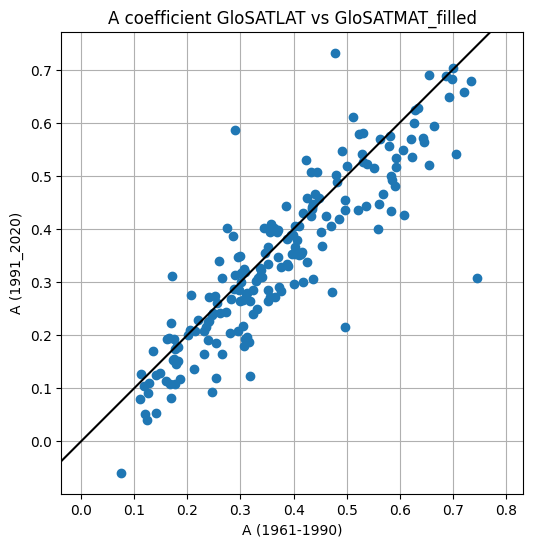

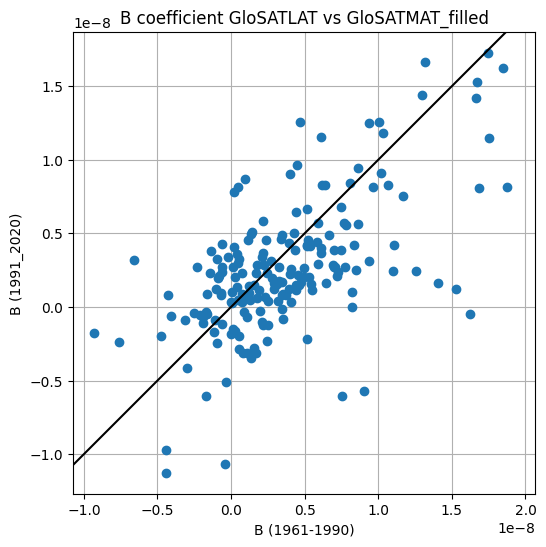

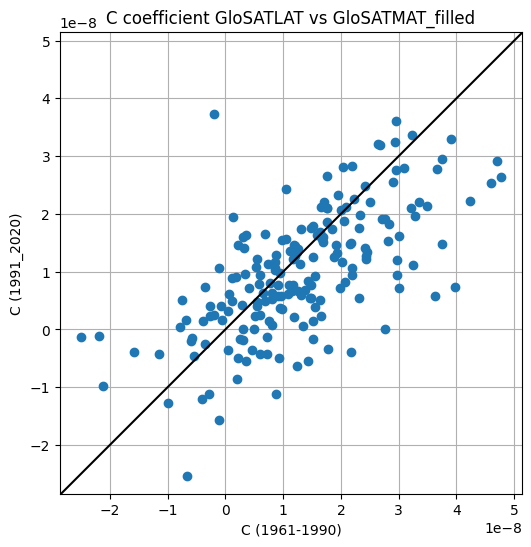

In [ ]:

# Flatten the cleaned coefficient grids for comparison
A_1961_1990_flat_cleaned = A_grid_cleaned_1961_1990.flatten()
A_1991_2020_flat_cleaned = A_grid_cleaned_1991_2020.flatten()

B_1961_1990_flat_cleaned = B_grid_cleaned_1961_1990.flatten()
B_1991_2020_flat_cleaned = B_grid_cleaned_1991_2020.flatten()

C_1961_1990_flat_cleaned = C_grid_cleaned_1961_1990.flatten()
C_1991_2020_flat_cleaned = C_grid_cleaned_1991_2020.flatten()

# Scatter plot comparison for A coefficients without outliers
scatter_plot_coefficients(A_1961_1990_flat_cleaned, A_1991_2020_flat_cleaned,
                          "A coefficient GloSATLAT vs GloSATMAT_filled",
                          "A (1961-1990)", "A (1991_2020)")

# Scatter plot comparison for B coefficients without outliers
scatter_plot_coefficients(B_1961_1990_flat_cleaned, B_1991_2020_flat_cleaned,
                          "B coefficient GloSATLAT vs GloSATMAT_filled",
                          "B (1961-1990)", "B (1991_2020)")

# Scatter plot comparison for C coefficients without outliers
scatter_plot_coefficients(C_1961_1990_flat_cleaned, C_1991_2020_flat_cleaned,
                          "C coefficient GloSATLAT vs GloSATMAT_filled",
                          "C (1961-1990)", "C (1991_2020)")

# Function for Latitidinal boxplot with median

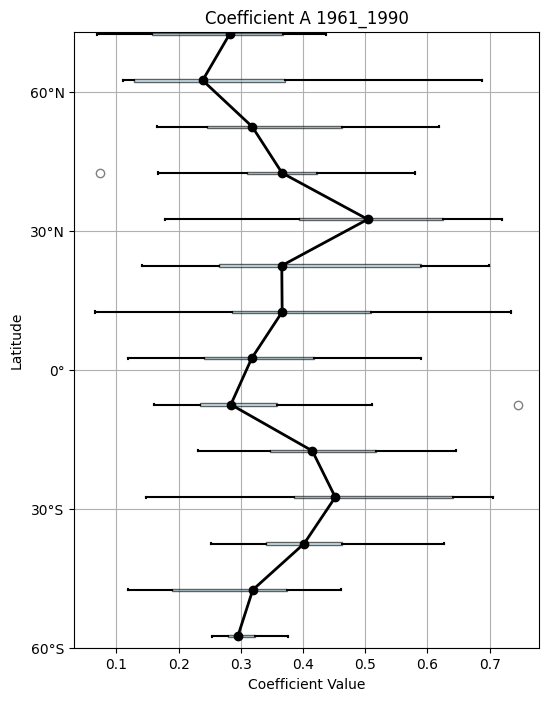

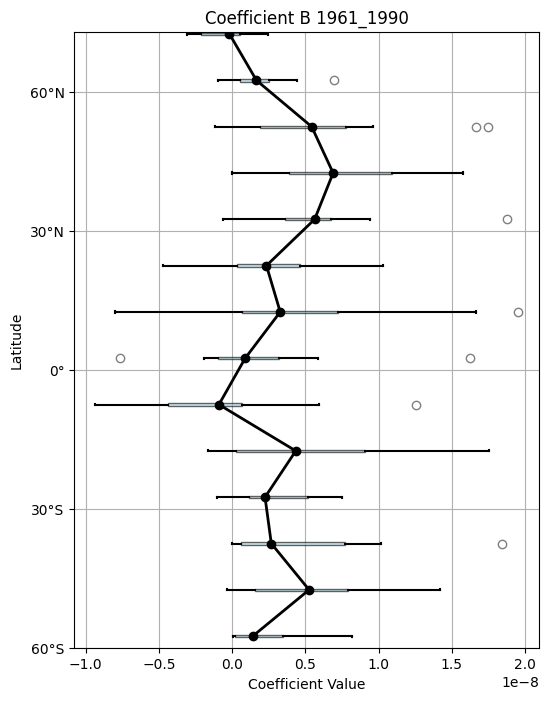

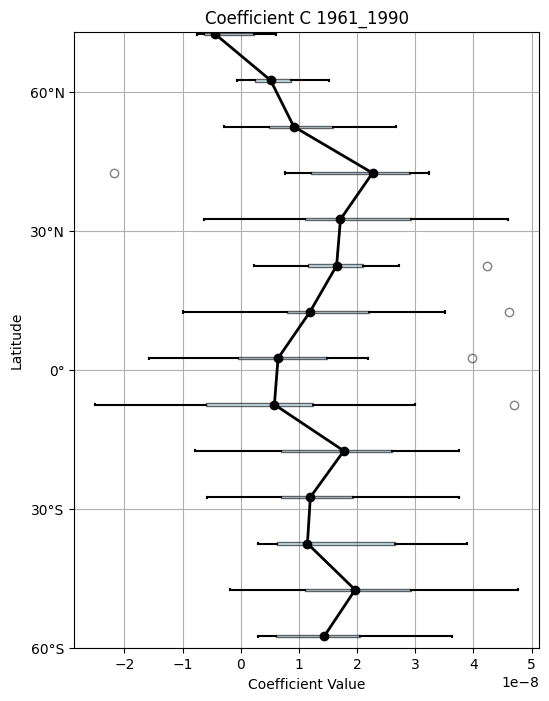

In [ ]:
def plot_custom_boxplot_with_medians(coefficient, latitudes, title):
    # Convert data to pandas DataFrame for easier processing
    df = pd.DataFrame({'Latitude': latitudes, 'Coefficient': coefficient})

    # Drop rows with NaN coefficient values
    df = df.dropna(subset=['Coefficient'])

    plt.figure(figsize=(6, 8))

    # Prepare data for boxplot
    latitude_bins = np.unique(df['Latitude'])
    boxplot_data = [df[df['Latitude'] == lat]['Coefficient'].dropna() for lat in latitude_bins]

    # Create the boxplot
    box = plt.boxplot(boxplot_data, vert=False, positions=latitude_bins, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='black'),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'),
                      flierprops=dict(marker='o', color='black', alpha=0.5))

    # Shading for the interquartile range (IQR)
    for patch in box['boxes']:
        patch.set(facecolor='lightblue', alpha=0.6)

    # Whiskers and caps
    for whisker in box['whiskers']:
        whisker.set(color='black', linewidth=1.5)

    for cap in box['caps']:
        cap.set(color='black', linewidth=1.5)

    # Median line properties
    for median in box['medians']:
        median.set(color='black', linewidth=2)

    # Plotting outliers
    for flier in box['fliers']:
        flier.set(marker='o', color='black', alpha=0.5)

    # Calculating the median for each latitude bin
    median_coefficients = [data.median() for data in boxplot_data]

    # Plot the median line with connecting points
    plt.plot(median_coefficients, latitude_bins, 'o-', color='black', linewidth=2)

    # Set y-axis to specific ticks
    plt.yticks(ticks=np.arange(-60, 70, 30), labels=['60°S', '30°S', '0°', '30°N', '60°N'])

    # Set x-axis label, y-axis label, and title
    plt.xlabel('Coefficient Value')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_custom_boxplot_with_medians(A_grid_cleaned_1961_1990.flatten(), np.repeat(reduced_latitudes, A_grid_cleaned_1961_1990.shape[1]), "Coefficient A 1961_1990")
plot_custom_boxplot_with_medians(B_grid_cleaned_1961_1990.flatten(), np.repeat(reduced_latitudes, B_grid_cleaned_1961_1990.shape[1]), "Coefficient B 1961_1990")
plot_custom_boxplot_with_medians(C_grid_cleaned_1961_1990.flatten(), np.repeat(reduced_latitudes, C_grid_cleaned_1961_1990.shape[1]), "Coefficient C 1961_1990")


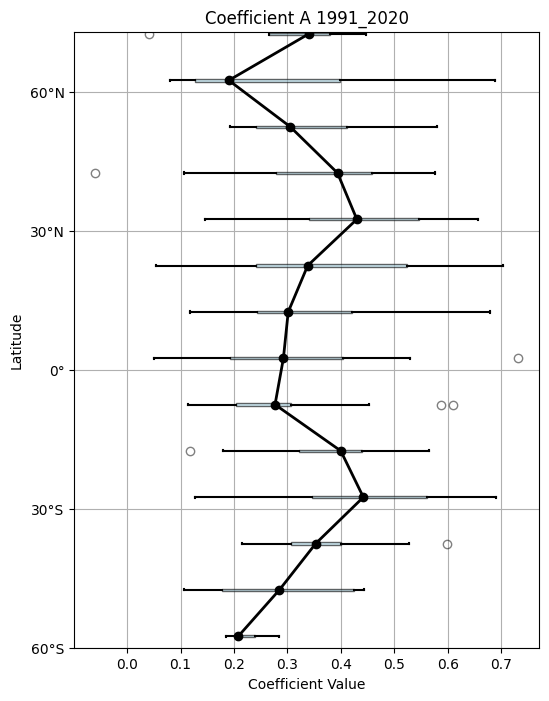

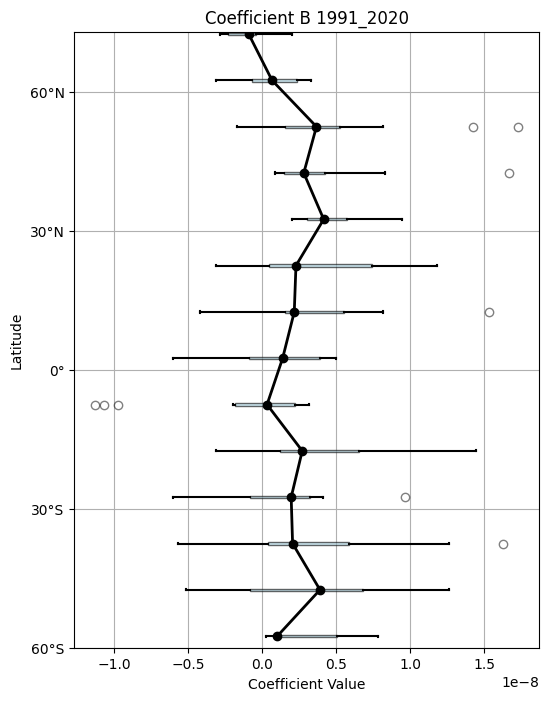

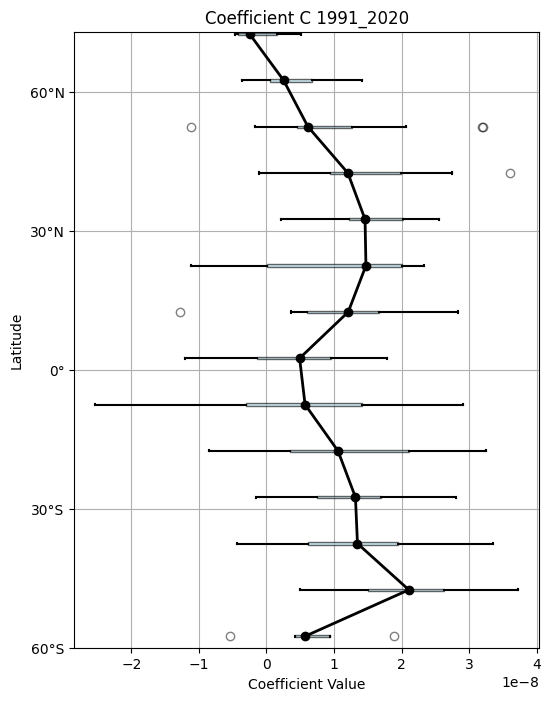

In [ ]:
plot_custom_boxplot_with_medians(A_grid_cleaned_1991_2020.flatten(), np.repeat(reduced_latitudes, A_grid_cleaned_1991_2020.shape[1]), "Coefficient A 1991_2020")
plot_custom_boxplot_with_medians(B_grid_cleaned_1991_2020.flatten(), np.repeat(reduced_latitudes, B_grid_cleaned_1991_2020.shape[1]), "Coefficient B 1991_2020")
plot_custom_boxplot_with_medians(C_grid_cleaned_1991_2020.flatten(), np.repeat(reduced_latitudes, C_grid_cleaned_1991_2020.shape[1]), "Coefficient C 1991_2020")

# Funtion for Spatial coefficeint analysis

In [ ]:
def plot_coefficient_spatially(latitudes, longitudes, coefficient, title, scale_factor=1, unit=''):
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    lons, lats = np.meshgrid(longitudes, latitudes)
    c = ax.pcolormesh(lons, lats, coefficient * scale_factor, cmap='coolwarm', shading='auto', vmin=np.nanmin(coefficient * scale_factor), vmax=np.nanmax(coefficient * scale_factor))
    ax.coastlines()
    ax.set_title(title)
    cbar = fig.colorbar(c, ax=ax, orientation='vertical', pad=0.05, location='left')
    cbar.set_label(unit)
    plt.show()

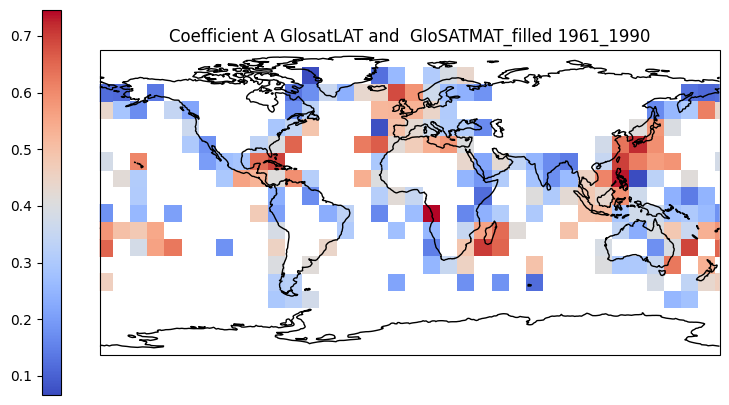

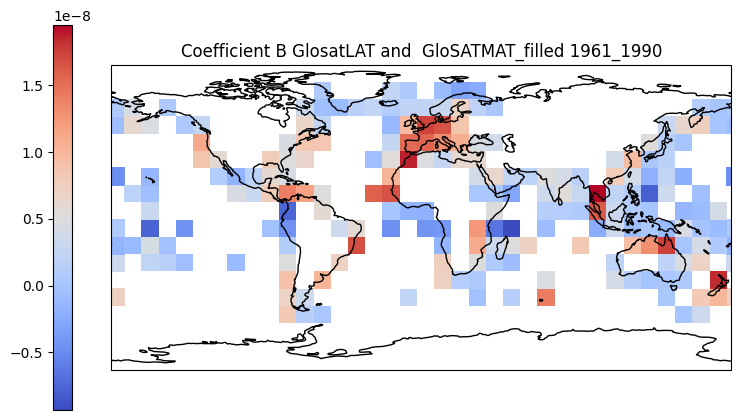

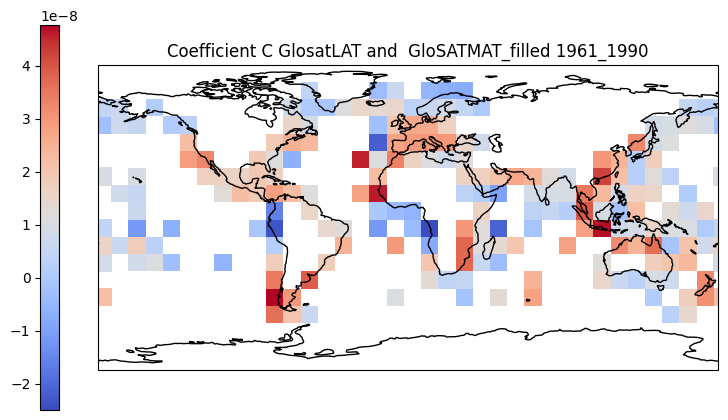

In [ ]:
# Plot the spatial distribution of the coefficients
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, A_grid_cleaned_1961_1990, "Coefficient A GlosatLAT and  GloSATMAT_filled 1961_1990")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, B_grid_cleaned_1961_1990, "Coefficient B GlosatLAT and  GloSATMAT_filled 1961_1990")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, C_grid_cleaned_1961_1990, "Coefficient C GlosatLAT and  GloSATMAT_filled 1961_1990")

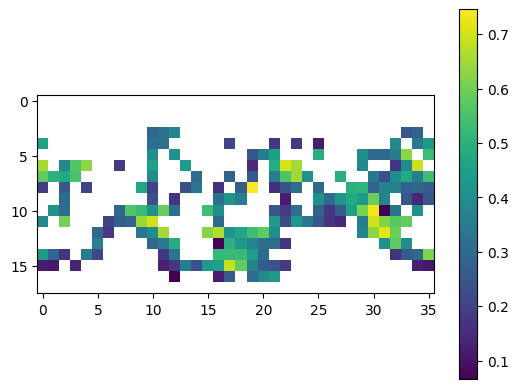

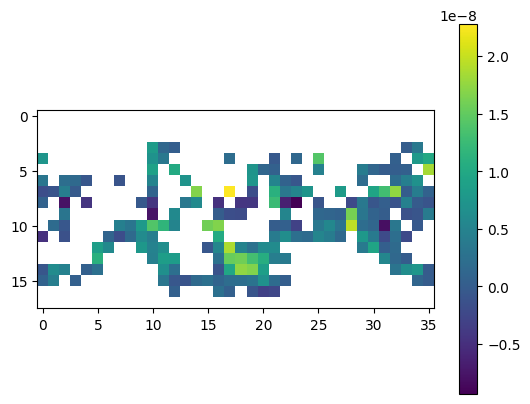

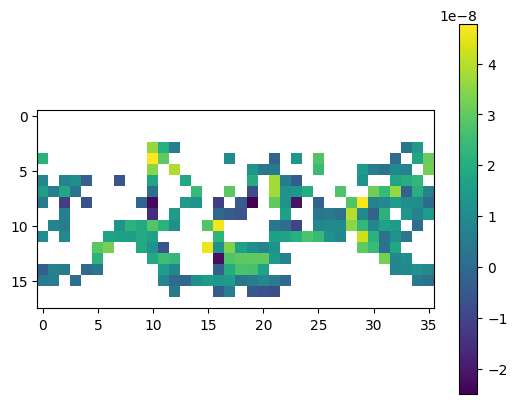

In [ ]:
plt.imshow(A_grid_1961_1990)
plt.colorbar()
plt.show()
plt.imshow(B_grid_1961_1990)
plt.colorbar()
plt.show()
plt.imshow(C_grid_1961_1990)
plt.colorbar()
plt.show()


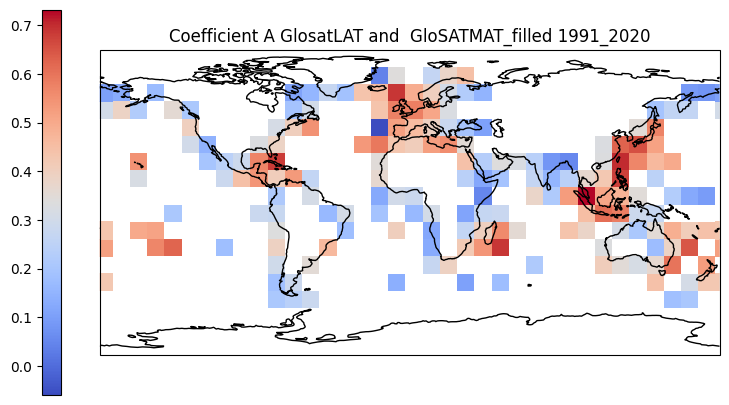

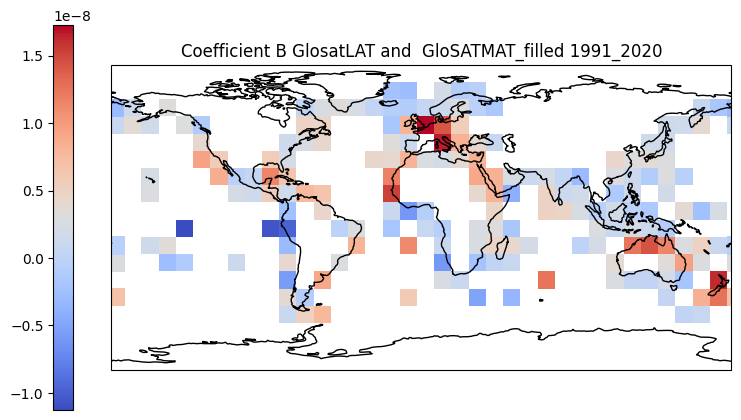

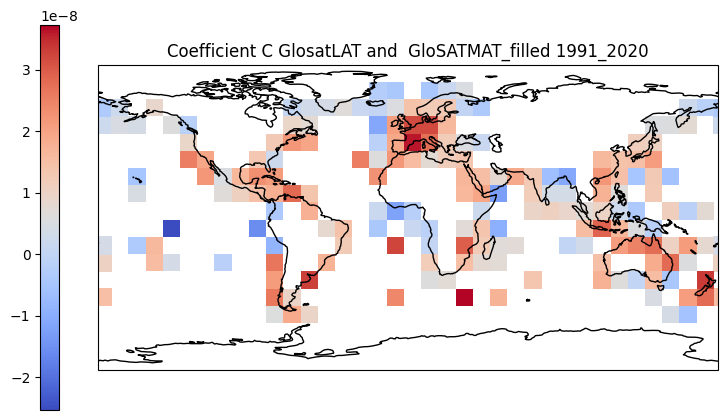

In [ ]:
# Plot the spatial distribution of the coefficients
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, A_grid_cleaned_1991_2020, "Coefficient A GlosatLAT and  GloSATMAT_filled 1991_2020")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, B_grid_cleaned_1991_2020, "Coefficient B GlosatLAT and  GloSATMAT_filled 1991_2020")
plot_coefficient_spatially(reduced_latitudes, reduced_longitudes, C_grid_cleaned_1991_2020, "Coefficient C GlosatLAT and  GloSATMAT_filled 1991_2020")

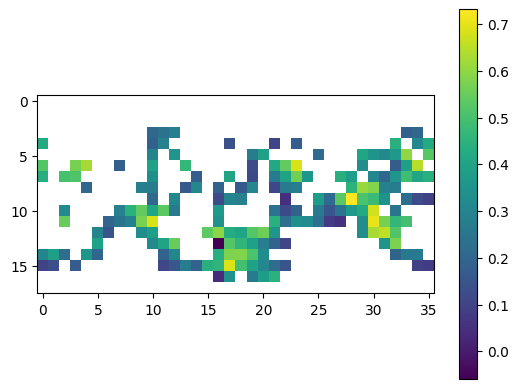

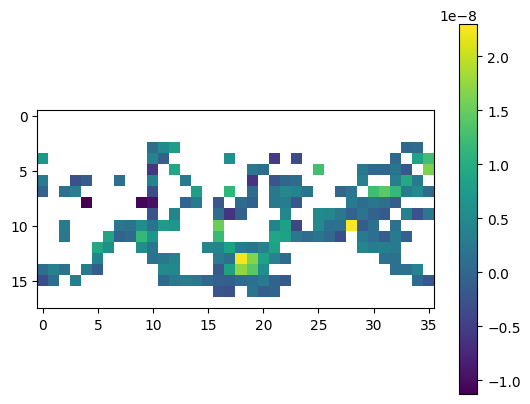

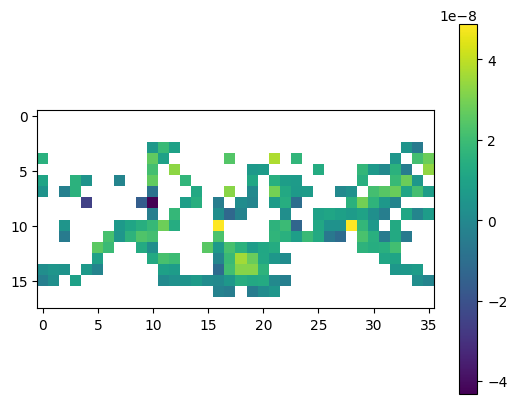

In [ ]:
plt.imshow(A_grid_1991_2020)
plt.colorbar()
plt.show()
plt.imshow(B_grid_1991_2020)
plt.colorbar()
plt.show()
plt.imshow(C_grid_1991_2020)
plt.colorbar()
plt.show()



# Function for calculating the Pearson Correlation between two periods of Coefficient values(1961-1990 and 1991-2020)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def calculate_pearson_correlation(coef_1961_1990, coef_1991_2020):
    # Flatten the arrays and remove NaN values for correlation calculation
    flat_1961_1990 = coef_1961_1990.flatten()
    flat_1991_2020 = coef_1991_2020.flatten()

    # Remove NaNs from both arrays
    mask = ~np.isnan(flat_1961_1990) & ~np.isnan(flat_1991_2020)
    clean_1961_1990 = flat_1961_1990[mask]
    clean_1991_2020 = flat_1991_2020[mask]

    # Calculate Pearson correlation
    correlation, _ = pearsonr(clean_1961_1990, clean_1991_2020)

    return correlation

# Example usage
A_correlation = calculate_pearson_correlation(A_grid_1961_1990, A_grid_1991_2020)
B_correlation = calculate_pearson_correlation(B_grid_1961_1990, B_grid_1991_2020)
C_correlation = calculate_pearson_correlation(C_grid_1961_1990, C_grid_1991_2020)
print("Pearson coefficient of grid values for GlosatLAT vs  GloSATMAT filled 1961_1990 and 1991_2020 ")
print(f"Pearson Correlation Coefficient for Coefficient A: {A_correlation}")
print(f"Pearson Correlation Coefficient for Coefficient B: {B_correlation}")
print(f"Pearson Correlation Coefficient for Coefficient C: {C_correlation}")


Pearson coefficient of grid values for GlosatLAT vs  GloSATMAT filled 1961_1990 and 1991_2020 
Pearson Correlation Coefficient for Coefficient A: 0.8870145180118416
Pearson Correlation Coefficient for Coefficient B: 0.657534852527832
Pearson Correlation Coefficient for Coefficient C: 0.6867989208525717
